In [19]:
import torch
import numpy as np
from dataset import CBISDDSMDataset
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
from run import load_model
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

In [104]:
batch_size = 128
test_dataset = CBISDDSMDataset(train=False)
test_dataloader = DataLoader(test_dataset, 
                             batch_size=batch_size,
                             shuffle=True)
ds_size = len(test_dataset)

Loading /Users/miclin/Developer/bdrad/dicom/mass_case_description_test_set.csv...
257 entries loaded in testing dataset


In [105]:
model = load_model()

In [106]:
sample_batch, sample_expected, sample_predict = None, None, None
with torch.no_grad():
    for X, y in test_dataloader:
        sample_batch = X
        sample_expected = y
        sample_predict = model(X)
        break

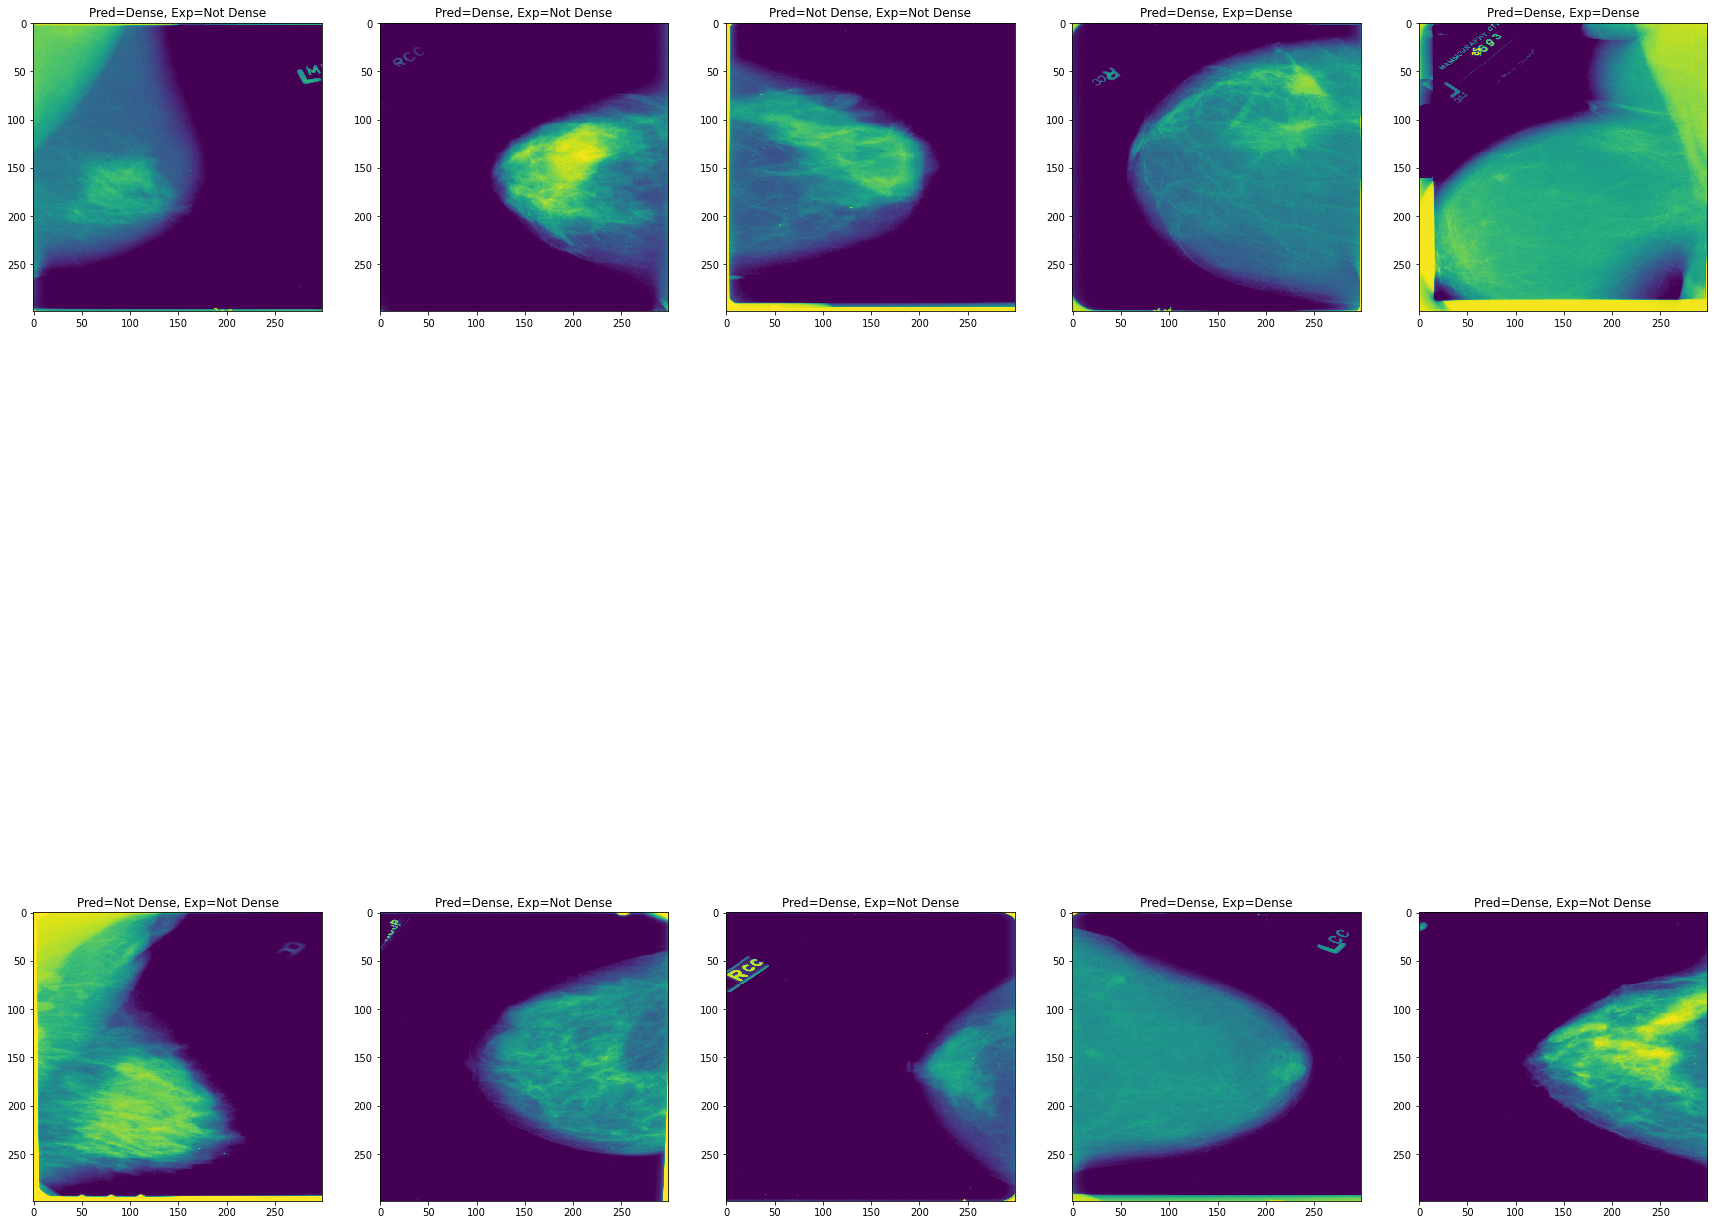

In [107]:
plot_size = (2, 5)
random_index = np.random.randint(0, batch_size, size=plot_size)
fig, axs = plt.subplots(*plot_size, figsize=(30, 30))
for row, row_values in enumerate(random_index):
    for col, val in enumerate(row_values):
        img = sample_batch[val][0]
        exp = sample_expected[val].argmax().item()
        pred = sample_predict[val].argmax().item()
        exp = "Dense" if exp else "Not Dense"
        pred = "Dense" if pred else "Not Dense"
        axs[row, col].imshow(img, interpolation='nearest')
        axs[row, col].set_title(f"Pred={pred}, Exp={exp}")

In [108]:
predicted, expected = [], []
with torch.no_grad():
    for X, y in test_dataloader:
        pred = model(X)
        predicted.extend(pred.argmax(1).tolist())
        expected.extend(y.argmax(1).tolist())

Accuracy (n=257): 79.4%


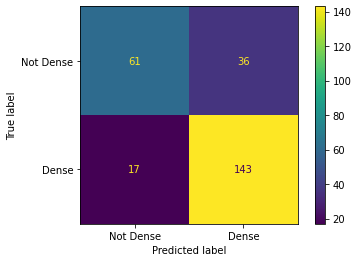

In [109]:
correct = sum([x == y for x, y in zip(predicted, expected)])
print(f"Accuracy (n={ds_size}): {(100*correct/ds_size):>0.1f}%")
labels = ["Not Dense", "Dense"]
ConfusionMatrixDisplay.from_predictions(expected, predicted, display_labels=labels)

In [110]:
import torch.nn.functional
import sklearn.metrics as metrics
sample_predict_prob = torch.nn.functional.softmax(sample_predict, dim=1)
fpr, tpr, threshold = metrics.roc_curve(sample_expected.argmax(1), sample_predict_prob[:, 1])

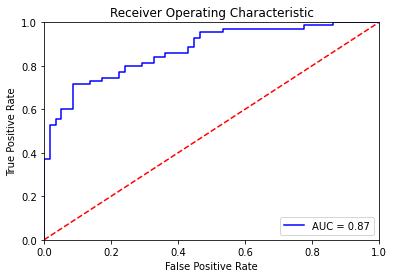

In [111]:
roc_auc = metrics.auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()